# **Dependencies**

In [ ]:
pip install transformers

In [ ]:
import tensorflow as tf

from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
os.environ["WANDB_API_KEY"] = "0"

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 21 05:51:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
max_length = 200
batch_size = 32
dev_size = 0.25

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# **MTL Experiments**

### **Dataset Preparation**

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
df = pd.read_csv('Fincorp.csv')
df = df.sample(frac = 1)

**Label Encoding**

In [ ]:
df['Emotion'] = le.fit_transform(df['Emotion'])
df['Severity level'] = le.fit_transform(df['Severity level'])
df['Sentiment'] = le.fit_transform(df['Sentiment'])

In [ ]:
df

,Domain,Complaint/ Opinion,Complaint Label,Severity level,Sentiment,Emotion
2995,Refund,@HDFCLIFE why you guys are just finding excuse...,1,2,0,5
4845,Economy,FCA has now entered the phase of its two-and-a...,0,4,2,4
5637,Stocks and investment,The Best HYIP Investment - Carzy Payment - Pay...,0,4,2,4
460,Loan,Funds on Hold\nAs on Date: 31 Dec 2021\nAmount...,1,3,0,5
1637,Stock,"@AirCanada worst company, no service. If you ...",1,2,0,5
...,...,...,...,...,...,...
4406,Economy,@CNBC @Grow_mag What a stupid advice… in one w...,0,4,1,4
2194,Tax,#ModiHaiToMumkinHai #NarendraModi @cbic_india ...,1,1,0,5
4759,Transaction,@Venmo Me! $1000 request or best you can do.,0,4,1,4
5525,Stocks and investment,@Sreekrisblr @ipo_mantra Sir\nPls quote some g...,0,4,2,4


### **Tokenization (RoBERTa)**

In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [ ]:
train_encoded = bert_encode(df['Complaint/ Opinion'].values.tolist())

New pandas Dataframe is being created with tokenized data and encoded labels, for easier splitting with startified 5 fold cross validation

In [ ]:
import scipy.sparse as sparse
pdx = pd.DataFrame()

In [ ]:
pdx['X'] = train_encoded.numpy().tolist()

In [ ]:
pdx['Y'] = df['Complaint Label'].values
pdx['Z'] = df['Severity level'].values
pdx['P'] = df['Sentiment'].values
pdx['Q'] = df['Emotion'].values

In [ ]:
pdx

,X,Y,Z,P,Q
0,"[0, 1039, 13022, 5268, 574, 40198, 596, 47, 16...",1,2,0,5
1,"[0, 5268, 250, 34, 122, 2867, 5, 4359, 9, 63, ...",0,4,2,4
2,"[0, 133, 2700, 38005, 3808, 2830, 111, 1653, 5...",0,4,2,4
3,"[0, 13632, 29, 15, 10357, 50118, 1620, 15, 105...",1,3,0,5
4,"[0, 1039, 17906, 14031, 1437, 2373, 138, 6, 11...",1,2,0,5
...,...,...,...,...,...
6276,"[0, 1039, 347, 19542, 787, 534, 4610, 1215, 16...",0,4,1,4
6277,"[0, 10431, 30597, 118, 725, 1439, 3972, 448, 7...",1,1,0,5
6278,"[0, 1039, 39043, 4992, 1464, 328, 68, 20078, 2...",0,4,1,4
6279,"[0, 1039, 104, 18230, 4663, 3662, 338, 787, 15...",0,4,2,4


### **Batched Dataset Creation**

In [ ]:
# For Single task experiments
def gen_data1(x,y,batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text , emo = x[index], y[index]

      x_batch[i] = text
      y_batch[i] = emo

    yield x_batch, y_batch

# For Tri-task Experiments
def gen_data3(x,y,z, p, batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))
    z_batch = np.zeros((batch_size, ))
    p_batch = np.zeros((batch_size, ))    

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text, comp, sev, sent, emo = x[index], y[index], z[index], p[index]

      x_batch[i] = text
      y_batch[i] = comp
      z_batch[i] = sev
      p_batch[i] = sent

    yield x_batch, [y_batch, z_batch, p_batch]

# For MTL experiments, ie all 4 tasks together
def gen_data4(x,y,z, p, q, batch_size=32):

  num_examples = len(y)

  while True:
    x_batch = np.zeros((batch_size, 200))
    y_batch = np.zeros((batch_size, ))
    z_batch = np.zeros((batch_size, ))
    p_batch = np.zeros((batch_size, ))
    q_batch = np.zeros((batch_size, ))

    for i in range(0, batch_size):

      index = np.random.randint(0, num_examples)
      text, comp, sev, sent, emo = x[index], y[index], z[index], p[index], q[index]

      x_batch[i] = text
      y_batch[i] = comp
      z_batch[i] = sev
      p_batch[i] = sent
      q_batch[i] = emo

    yield x_batch, [y_batch, z_batch, p_batch, q_batch]

### **Final Model compilation**

In [ ]:
from transformers import TFAutoModel
bert_encoder = TFAutoModel.from_pretrained("roberta-base")

In [ ]:
def bert_tweets_model():

    # Shared Layers - 1. RoBERTa embeddings 2. BiGRU layer 
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]    
    x = Bidirectional(tf.keras.layers.GRU(100, dropout=0.3, recurrent_dropout=0.3))(last_hidden_states)

    # Sentiment detection task (Auxiliary Task)
    output3 = tf.keras.layers.Dense(3, activation='softmax', name='sent')(x)

    # Emotion Detection task (Auxiliary Task)
    output4 = tf.keras.layers.Dense(7, activation='softmax', name='emo')(x)

    # Severity Detection Task with information from Auxiliary tasks fed
    add = tf.keras.layers.Concatenate(axis=1)([x, output3, output4])
    output2 = tf.keras.layers.Dense(5, activation='softmax', name='sev')(add)

    # Complaint Detection Task with information from Auxiliary tasks fed
    add = tf.keras.layers.Concatenate(axis=1)([x, output3, output4])
    output1 = tf.keras.layers.Dense(1, activation='sigmoid', name='comp')(add)

    model = tf.keras.Model(inputs=input_word_ids, outputs=[output1,output2,output3,output4])
    
    return model

In [ ]:
model_diag = bert_tweets_model()

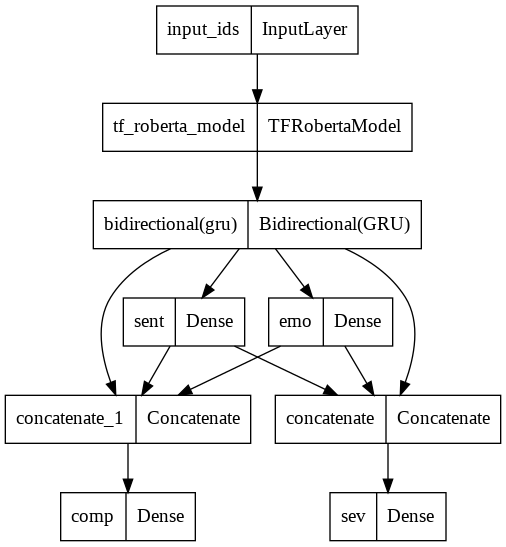

In [ ]:
tf.keras.utils.plot_model(model_diag)

### **5 fold CV with 3 epochs**

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn import StratifiedKFold


n=5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

results = []

for train_index, val_index in kfold.split(pdx, pdx['Y'].values):

    X_train_cv = pdx.iloc[train_index]
    y_train_cv = pdx.iloc[train_index]
    X_valid_cv = pdx.iloc[val_index]
    y_valid_cv= pdx.iloc[val_index]

    # train_encoded = X_train_cv['X']

    # gen_data(x,y,z, p,q, batch_size=32)

    train_gen = gen_data4(X_train_cv['X'].values, X_train_cv['Y'].values, X_train_cv['Z'].values, X_train_cv['P'].values, X_train_cv['Q'].values)
    test_gen = gen_data4(X_valid_cv['X'].values, X_valid_cv['Y'].values, X_valid_cv['Z'].values, X_valid_cv['P'].values, X_valid_cv['Q'].values)

    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    losses = {
    "sev": "sparse_categorical_crossentropy",
    "comp": "binary_crossentropy",
    "sent": "sparse_categorical_crossentropy",
    "emo": "sparse_categorical_crossentropy"
    }

    lossWeights = {"sev": 1.0, "comp": 1.0, "sent" : 0.5, "emo":0.5}

    model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

    # train the model
    _ = model.fit(
        train_gen,
        validation_data = test_gen,
        steps_per_epoch = 100, 
        validation_steps = 50,
        epochs = 3,
        verbose = True
        )

    # validate the model
    acc_cv = model.evaluate(train_gen,
                                       batch_size = 32,
                                       steps = 50,
                                       verbose = True)
    # print(result['acc'])
    # append model score
    results.append(acc_cv)


Epoch 1/3


100/100 [==============================] - 219s 2s/step - loss: 3.0179 - comp_loss: 0.5916 - sev_loss: 1.1452 - sent_loss: 0.9479 - emo_loss: 1.6145 - comp_accuracy: 0.6544 - sev_accuracy: 0.5472 - sent_accuracy: 0.5672 - emo_accuracy: 0.4184 - val_loss: 2.4189 - val_comp_loss: 0.3234 - val_sev_loss: 0.9406 - val_sent_loss: 0.8152 - val_emo_loss: 1.4945 - val_comp_accuracy: 0.8788 - val_sev_accuracy: 0.6137 - val_sent_accuracy: 0.6331 - val_emo_accuracy: 0.4575
Epoch 2/3
100/100 [==============================] - 196s 2s/step - loss: 2.1406 - comp_loss: 0.2579 - sev_loss: 0.7982 - sent_loss: 0.7608 - emo_loss: 1.4083 - comp_accuracy: 0.8972 - sev_accuracy: 0.6931 - sent_accuracy: 0.6391 - emo_accuracy: 0.4950 - val_loss: 1.9289 - val_comp_loss: 0.1915 - val_sev_loss: 0.7025 - val_sent_loss: 0.7561 - val_emo_loss: 1.3136 - val_comp_accuracy: 0.9369 - val_sev_accuracy: 0.7269 - val_sent_accuracy: 0.6562 - val_emo_accuracy: 0.5169
Epoch 3/3
50/50 [==============================] - 18s 355

Epoch 1/3


100/100 [==============================] - 218s 2s/step - loss: 1.8906 - comp_loss: 0.1678 - sev_loss: 0.6641 - sent_loss: 0.7304 - emo_loss: 1.3869 - comp_accuracy: 0.9444 - sev_accuracy: 0.7506 - sent_accuracy: 0.6575 - emo_accuracy: 0.5050 - val_loss: 1.5651 - val_comp_loss: 0.0868 - val_sev_loss: 0.5868 - val_sent_loss: 0.6022 - val_emo_loss: 1.1809 - val_comp_accuracy: 0.9706 - val_sev_accuracy: 0.7862 - val_sent_accuracy: 0.7256 - val_emo_accuracy: 0.5781
Epoch 2/3
100/100 [==============================] - 197s 2s/step - loss: 1.6658 - comp_loss: 0.1213 - sev_loss: 0.5924 - sent_loss: 0.6345 - emo_loss: 1.2699 - comp_accuracy: 0.9619 - sev_accuracy: 0.7828 - sent_accuracy: 0.6969 - emo_accuracy: 0.5453 - val_loss: 1.4995 - val_comp_loss: 0.0795 - val_sev_loss: 0.5080 - val_sent_loss: 0.6075 - val_emo_loss: 1.2165 - val_comp_accuracy: 0.9737 - val_sev_accuracy: 0.7981 - val_sent_accuracy: 0.7206 - val_emo_accuracy: 0.5519
Epoch 3/3
50/50 [==============================] - 18s 354

Epoch 1/3


100/100 [==============================] - 219s 2s/step - loss: 1.7484 - comp_loss: 0.1349 - sev_loss: 0.6100 - sent_loss: 0.6883 - emo_loss: 1.3187 - comp_accuracy: 0.9647 - sev_accuracy: 0.7750 - sent_accuracy: 0.6753 - emo_accuracy: 0.5166 - val_loss: 1.4334 - val_comp_loss: 0.0640 - val_sev_loss: 0.4744 - val_sent_loss: 0.6210 - val_emo_loss: 1.1691 - val_comp_accuracy: 0.9831 - val_sev_accuracy: 0.8325 - val_sent_accuracy: 0.7312 - val_emo_accuracy: 0.5794
Epoch 2/3
100/100 [==============================] - 197s 2s/step - loss: 1.4913 - comp_loss: 0.0936 - sev_loss: 0.5022 - sent_loss: 0.6143 - emo_loss: 1.1767 - comp_accuracy: 0.9737 - sev_accuracy: 0.8228 - sent_accuracy: 0.7078 - emo_accuracy: 0.5603 - val_loss: 1.3344 - val_comp_loss: 0.0426 - val_sev_loss: 0.4474 - val_sent_loss: 0.5673 - val_emo_loss: 1.1214 - val_comp_accuracy: 0.9887 - val_sev_accuracy: 0.8344 - val_sent_accuracy: 0.7450 - val_emo_accuracy: 0.5813
Epoch 3/3
50/50 [==============================] - 18s 354

Epoch 1/3


100/100 [==============================] - 218s 2s/step - loss: 1.5635 - comp_loss: 0.0900 - sev_loss: 0.5405 - sent_loss: 0.6161 - emo_loss: 1.2498 - comp_accuracy: 0.9803 - sev_accuracy: 0.8006 - sent_accuracy: 0.7194 - emo_accuracy: 0.5400 - val_loss: 1.4022 - val_comp_loss: 0.0582 - val_sev_loss: 0.4444 - val_sent_loss: 0.6309 - val_emo_loss: 1.1683 - val_comp_accuracy: 0.9837 - val_sev_accuracy: 0.8481 - val_sent_accuracy: 0.7300 - val_emo_accuracy: 0.5537
Epoch 2/3
100/100 [==============================] - 197s 2s/step - loss: 1.3952 - comp_loss: 0.0716 - sev_loss: 0.4556 - sent_loss: 0.5876 - emo_loss: 1.1484 - comp_accuracy: 0.9822 - sev_accuracy: 0.8438 - sent_accuracy: 0.7250 - emo_accuracy: 0.5722 - val_loss: 1.3883 - val_comp_loss: 0.0603 - val_sev_loss: 0.4380 - val_sent_loss: 0.6084 - val_emo_loss: 1.1716 - val_comp_accuracy: 0.9850 - val_sev_accuracy: 0.8444 - val_sent_accuracy: 0.7269 - val_emo_accuracy: 0.5656
Epoch 3/3
50/50 [==============================] - 18s 354

Epoch 1/3


100/100 [==============================] - 218s 2s/step - loss: 1.5734 - comp_loss: 0.0853 - sev_loss: 0.5059 - sent_loss: 0.6516 - emo_loss: 1.3129 - comp_accuracy: 0.9784 - sev_accuracy: 0.8125 - sent_accuracy: 0.6969 - emo_accuracy: 0.5231 - val_loss: 1.2733 - val_comp_loss: 0.0454 - val_sev_loss: 0.3767 - val_sent_loss: 0.5602 - val_emo_loss: 1.1422 - val_comp_accuracy: 0.9869 - val_sev_accuracy: 0.8750 - val_sent_accuracy: 0.7494 - val_emo_accuracy: 0.5644
Epoch 2/3
100/100 [==============================] - 195s 2s/step - loss: 1.2755 - comp_loss: 0.0515 - sev_loss: 0.3970 - sent_loss: 0.5540 - emo_loss: 1.1001 - comp_accuracy: 0.9859 - sev_accuracy: 0.8609 - sent_accuracy: 0.7516 - emo_accuracy: 0.5900 - val_loss: 1.2953 - val_comp_loss: 0.0670 - val_sev_loss: 0.3893 - val_sent_loss: 0.5418 - val_emo_loss: 1.1363 - val_comp_accuracy: 0.9856 - val_sev_accuracy: 0.8669 - val_sent_accuracy: 0.7581 - val_emo_accuracy: 0.5594
Epoch 3/3
50/50 [==============================] - 18s 353

### **Checking batches**

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import StratifiedKFold


n=5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

results = []

for train_index, val_index in kfold.split(pdx, pdx['Y'].values):

    X_train_cv = pdx.iloc[train_index]
    y_train_cv = pdx.iloc[train_index]
    X_valid_cv = pdx.iloc[val_index]
    y_valid_cv= pdx.iloc[val_index]

    # print(X_train_cv)
    # print(train_index.shape)
    # print(X_valid_cv)
    # print(val_index.shape)
    # train_encoded = X_train_cv['X']

    # gen_data(x,y,z, p,q, batch_size=32)

    train_gen = gen_data4(X_train_cv['X'].values, X_train_cv['Y'].values, X_train_cv['Z'].values, X_train_cv['P'].values, X_train_cv['Q'].values)
    test_gen = gen_data4(X_valid_cv['X'].values, X_valid_cv['Y'].values, X_valid_cv['Z'].values, X_valid_cv['P'].values, X_valid_cv['Q'].values)

    model = bert_tweets_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

    losses = {
    "comp": "binary_crossentropy",
    "sev": "sparse_categorical_crossentropy",
    "sent": "sparse_categorical_crossentropy",
    "emo": "sparse_categorical_crossentropy"
    }

    lossWeights = {"comp": 1.0, "sev": 1.0,  "sent" : 0.5, "emo":0.5}

    model.compile(loss=losses,loss_weights=lossWeights, optimizer=adam_optimizer,metrics=['accuracy'])

    # train the model
    _ = model.fit(
        train_gen,
        validation_data = test_gen,
        steps_per_epoch = 100, 
        validation_steps = 50,
        epochs = 3,
        verbose = True
        )

    # validate the model
    acc_cv = model.evaluate(train_gen,
                            batch_size = 32,
                            steps = 50,
                            verbose = True)
    # print(result['acc'])
    # append model score
    results.append(acc_cv)


Epoch 1/3


100/100 [==============================] - 277s 3s/step - loss: 3.1880 - comp_loss: 0.6580 - sev_loss: 1.2178 - sent_loss: 0.9675 - emo_loss: 1.6569 - comp_accuracy: 0.6037 - sev_accuracy: 0.5194 - sent_accuracy: 0.5672 - emo_accuracy: 0.3997 - val_loss: 3.0028 - val_comp_loss: 0.5440 - val_sev_loss: 1.1540 - val_sent_loss: 0.9282 - val_emo_loss: 1.6813 - val_comp_accuracy: 0.7169 - val_sev_accuracy: 0.5619 - val_sent_accuracy: 0.5869 - val_emo_accuracy: 0.4175
Epoch 2/3
100/100 [==============================] - 247s 2s/step - loss: 2.5636 - comp_loss: 0.4292 - sev_loss: 0.9633 - sent_loss: 0.8613 - emo_loss: 1.4808 - comp_accuracy: 0.8028 - sev_accuracy: 0.6378 - sent_accuracy: 0.6019 - emo_accuracy: 0.4712 - val_loss: 2.1689 - val_comp_loss: 0.2532 - val_sev_loss: 0.8114 - val_sent_loss: 0.7620 - val_emo_loss: 1.4466 - val_comp_accuracy: 0.8981 - val_sev_accuracy: 0.6925 - val_sent_accuracy: 0.6875 - val_emo_accuracy: 0.5025
Epoch 3/3
50/50 [==============================] - 19s 389

Epoch 1/3


100/100 [==============================] - 275s 3s/step - loss: 2.0507 - comp_loss: 0.2024 - sev_loss: 0.7738 - sent_loss: 0.7408 - emo_loss: 1.4081 - comp_accuracy: 0.9350 - sev_accuracy: 0.6994 - sent_accuracy: 0.6559 - emo_accuracy: 0.5091 - val_loss: 1.6112 - val_comp_loss: 0.1041 - val_sev_loss: 0.5684 - val_sent_loss: 0.6303 - val_emo_loss: 1.2470 - val_comp_accuracy: 0.9737 - val_sev_accuracy: 0.7900 - val_sent_accuracy: 0.7088 - val_emo_accuracy: 0.5531
Epoch 2/3
100/100 [==============================] - 247s 2s/step - loss: 1.6691 - comp_loss: 0.1164 - sev_loss: 0.6135 - sent_loss: 0.6199 - emo_loss: 1.2584 - comp_accuracy: 0.9641 - sev_accuracy: 0.7725 - sent_accuracy: 0.7163 - emo_accuracy: 0.5462 - val_loss: 1.6104 - val_comp_loss: 0.0964 - val_sev_loss: 0.5201 - val_sent_loss: 0.7006 - val_emo_loss: 1.2872 - val_comp_accuracy: 0.9700 - val_sev_accuracy: 0.7981 - val_sent_accuracy: 0.7006 - val_emo_accuracy: 0.5356
Epoch 3/3
50/50 [==============================] - 19s 389

Epoch 1/3


100/100 [==============================] - 275s 3s/step - loss: 1.7399 - comp_loss: 0.1267 - sev_loss: 0.6205 - sent_loss: 0.6694 - emo_loss: 1.3161 - comp_accuracy: 0.9594 - sev_accuracy: 0.7675 - sent_accuracy: 0.7044 - emo_accuracy: 0.5278 - val_loss: 1.5251 - val_comp_loss: 0.0812 - val_sev_loss: 0.5813 - val_sent_loss: 0.5755 - val_emo_loss: 1.1496 - val_comp_accuracy: 0.9762 - val_sev_accuracy: 0.7800 - val_sent_accuracy: 0.7462 - val_emo_accuracy: 0.5781
Epoch 2/3
100/100 [==============================] - 248s 2s/step - loss: 1.5437 - comp_loss: 0.0878 - sev_loss: 0.5378 - sent_loss: 0.6218 - emo_loss: 1.2143 - comp_accuracy: 0.9741 - sev_accuracy: 0.8037 - sent_accuracy: 0.7175 - emo_accuracy: 0.5559 - val_loss: 1.4776 - val_comp_loss: 0.0740 - val_sev_loss: 0.5701 - val_sent_loss: 0.5455 - val_emo_loss: 1.1215 - val_comp_accuracy: 0.9812 - val_sev_accuracy: 0.7788 - val_sent_accuracy: 0.7594 - val_emo_accuracy: 0.5969
Epoch 3/3
50/50 [==============================] - 19s 387

Epoch 1/3


100/100 [==============================] - 276s 3s/step - loss: 1.6705 - comp_loss: 0.1130 - sev_loss: 0.5642 - sent_loss: 0.6599 - emo_loss: 1.3268 - comp_accuracy: 0.9631 - sev_accuracy: 0.7866 - sent_accuracy: 0.6925 - emo_accuracy: 0.5034 - val_loss: 1.3402 - val_comp_loss: 0.0589 - val_sev_loss: 0.4144 - val_sent_loss: 0.5898 - val_emo_loss: 1.1440 - val_comp_accuracy: 0.9825 - val_sev_accuracy: 0.8481 - val_sent_accuracy: 0.7369 - val_emo_accuracy: 0.5569
Epoch 2/3
100/100 [==============================] - 249s 2s/step - loss: 1.3377 - comp_loss: 0.0444 - sev_loss: 0.4458 - sent_loss: 0.5797 - emo_loss: 1.1151 - comp_accuracy: 0.9894 - sev_accuracy: 0.8334 - sent_accuracy: 0.7266 - emo_accuracy: 0.5859 - val_loss: 1.3854 - val_comp_loss: 0.0712 - val_sev_loss: 0.4788 - val_sent_loss: 0.5462 - val_emo_loss: 1.1245 - val_comp_accuracy: 0.9825 - val_sev_accuracy: 0.8331 - val_sent_accuracy: 0.7556 - val_emo_accuracy: 0.5900
Epoch 3/3
50/50 [==============================] - 19s 387

Epoch 1/3


100/100 [==============================] - 277s 3s/step - loss: 1.5631 - comp_loss: 0.0950 - sev_loss: 0.5249 - sent_loss: 0.6450 - emo_loss: 1.2413 - comp_accuracy: 0.9787 - sev_accuracy: 0.8066 - sent_accuracy: 0.7081 - emo_accuracy: 0.5553 - val_loss: 1.2436 - val_comp_loss: 0.0560 - val_sev_loss: 0.3479 - val_sent_loss: 0.5979 - val_emo_loss: 1.0816 - val_comp_accuracy: 0.9856 - val_sev_accuracy: 0.8819 - val_sent_accuracy: 0.7581 - val_emo_accuracy: 0.5987
Epoch 2/3
100/100 [==============================] - 249s 2s/step - loss: 1.2939 - comp_loss: 0.0498 - sev_loss: 0.4172 - sent_loss: 0.5399 - emo_loss: 1.1140 - comp_accuracy: 0.9884 - sev_accuracy: 0.8494 - sent_accuracy: 0.7531 - emo_accuracy: 0.5909 - val_loss: 1.2331 - val_comp_loss: 0.0580 - val_sev_loss: 0.3569 - val_sent_loss: 0.5681 - val_emo_loss: 1.0684 - val_comp_accuracy: 0.9875 - val_sev_accuracy: 0.8813 - val_sent_accuracy: 0.7531 - val_emo_accuracy: 0.6025
Epoch 3/3
50/50 [==============================] - 19s 389

### Saving the model for now, the predictions can be obtained on a new dataset without labels later

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model.save('/content/gdrive/MyDrive')

In [ ]:
# y_pred_train = model.predict(train_encoded)